### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/2023_AN2DL/Homework

Mounted at /gdrive
/gdrive/My Drive/2023_AN2DL/Homework


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load data

In [ ]:
#Unzip dataset
unzip = True

# Unzip the 'animals.zip' file if the 'unzip' flag is True
if unzip:
    !unzip training_dataset.zip

In [ ]:
dataset = np.load('training_data.npy')
# Convert into pandas dataframe
dataset = pd.DataFrame.from_dict(dataset)
print(dataset.shape)


(48000, 2776)


In [ ]:
start_end_dataset = np.load('valid_periods.npy')
start_end_dataset = pd.DataFrame.from_dict(start_end_dataset)
print(start_end_dataset.shape)

(48000, 2)


# Inspect data

In [ ]:
dataset[dataset.columns[2320:2330]]

,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329
0,0.0,0.0,0.0,0.0,0.0,0.491667,0.524074,0.544444,0.463889,0.406481
1,0.0,0.0,0.0,0.0,0.0,0.480000,0.500000,0.588000,0.420000,0.288000
2,0.0,0.0,0.0,0.0,0.0,0.007404,0.000000,0.017955,0.020916,0.027580
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
47995,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
47996,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
47997,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
47998,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
count = (dataset[1] != 0).sum()
print(count)

1


In [ ]:
print(dataset.index[dataset[1]!=0])

Int64Index([17143], dtype='int64')


In [ ]:
print(dataset.loc[17143])

0       0.183319
1       0.178061
2       0.171051
3       0.166542
4       0.165793
          ...   
2771    0.260920
2772    0.267974
2773    0.272139
2774    0.269904
2775    0.262239
Name: 17143, Length: 2776, dtype: float64


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
dataset = dataset.astype(np.float32)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
start_end_dataset = start_end_dataset.astype(np.float32)
start_end_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       48000 non-null  float32
 1   1       48000 non-null  float32
dtypes: float32(2)
memory usage: 375.1 KB


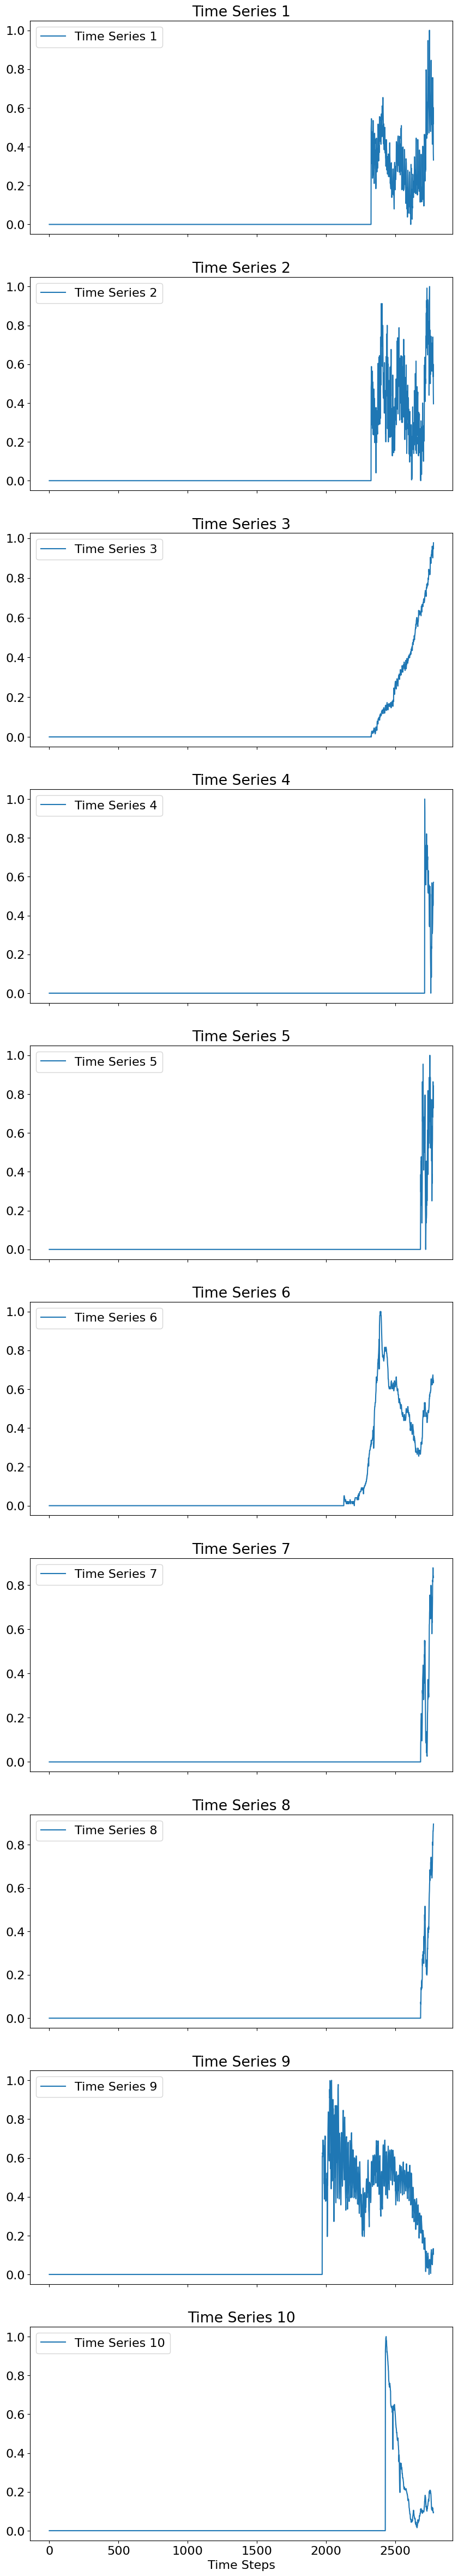

In [ ]:
def inspect_dataframe(df, num_time_series=10):
    fig, axs = plt.subplots(num_time_series, 1, sharex=True, figsize=(10, 6*num_time_series))
    for i in range(num_time_series):
        axs[i].plot(df.iloc[i, :], label=f'Time Series {i+1}')
        axs[i].set_title(f'Time Series {i+1}')
        axs[i].legend()
    plt.xlabel('Time Steps')
    plt.show()

inspect_dataframe(dataset)

# Manage time series

In [ ]:
# Extracting the first row from the first dataset
first_row = dataset.iloc[0]

# Extracting the start and end positions from the second dataset for the first time series
start_position = start_end_dataset.iloc[0, 0]  # Assuming the start position is in the first column
end_position = start_end_dataset.iloc[0, 1]  # Assuming the end position is in the second column

print(start_position, end_position)

# Extract the time series data using start and end positions
time_series = first_row[start_position:end_position]  # Adjust indexing as needed

# Define the ratio for splitting
train_ratio = 0.8

# Calculate lengths for training and test sets
total_length = len(time_series)
train_length = int(train_ratio * total_length)
test_length = total_length - train_length

# Splitting the time series data into training and test sets
train_data = time_series[:train_length]
test_data = time_series[train_length:]

# Printing the lengths of training and test sets for verification
print(f"Training data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")


2325 2776
Training data length: 360
Test data length: 91


In [ ]:
# Initialize lists to store training and test data for all time series
all_train_data = []
all_test_data = []

# Loop through each row in the dataset
for index, row in dataset.iterrows():
    # Extract the start and end positions for the current time series
    start_position = start_end_dataset.iloc[index, 0]  # Assuming start position is in the first column
    end_position = start_end_dataset.iloc[index, 1]    # Assuming end position is in the second column

    # Extract the time series data using start and end positions
    time_series = row[start_position:end_position]  # Adjust indexing as needed

    # Define the ratio for splitting
    train_ratio = 0.8

    # Calculate lengths for training and test sets
    total_length = len(time_series)
    train_length = int(train_ratio * total_length)
    test_length = total_length - train_length

    # Split the time series data into training and test sets
    train_data = time_series[:train_length]
    test_data = time_series[train_length:]

    # Append the training and test data for the current time series to the lists
    all_train_data.append(train_data)
    all_test_data.append(test_data)


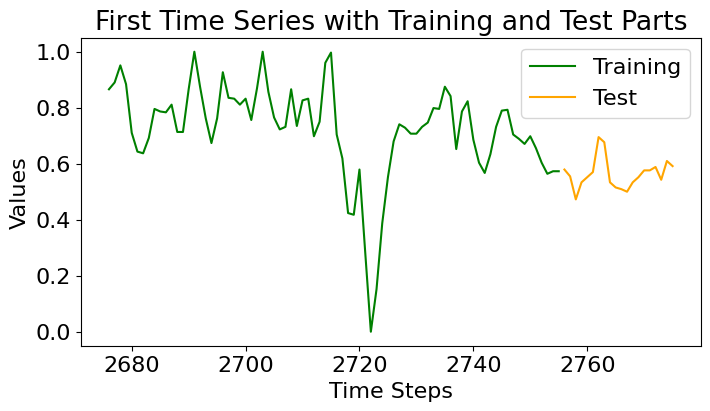

In [ ]:
# Plotting the first row with different colors for training and test parts
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(train_data, color='green', label='Training')  # Plot the training data in green
plt.plot(test_data, color='orange', label='Test')  # Plot the test data in orange
plt.legend()
plt.title('First Time Series with Training and Test Parts')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()


In [ ]:
all_train_data = pd.DataFrame.from_dict(all_train_data)
all_test_data = pd.DataFrame.from_dict(all_test_data)
print(all_train_data.shape, all_test_data.shape)

(48000, 2771) (48000, 556)


In [ ]:
window=200
stride=5
direct_telescope=18

In [ ]:
def build_sequences(df, window=200, stride=20, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = np.copy(df)
    padding_check = len(df) % window

    if padding_check != 0:
        # Compute padding length
        padding_len = window - len(df) % window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding, df))
        assert len(temp_df) % window == 0

    for idx in np.arange(0, len(temp_df) - window - telescope, stride):
        #dataset.append(temp_df[idx:idx + window])
        #labels.append(temp_df[idx + window:idx + window + telescope, 0])
        dataset.append(temp_df[idx:idx + window, 0][:, np.newaxis])
        labels.append(temp_df[idx + window:idx + window + telescope, 0][:, np.newaxis])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(dataset, window, stride, direct_telescope)
X_train.shape, y_train.shape

# Model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
print(input_shape)
print(output_shape)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    x = tf.keras.layers.Flatten()(x)

    # Add a Dense layer to match the required output shape
    x = tf.keras.layers.Dense(output_shape[0] * output_shape[1])(x)

    # Reshape to match the desired output shape
    x = tf.keras.layers.Reshape(output_shape, name='reshape')(x)

    # Remove the last dimension
    output_layer = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
135/135 [==============================] - 80s 469ms/step - loss: 0.3582 - val_loss: 4.5843e-06 - lr: 0.0010
Epoch 2/200
135/135 [==============================] - 61s 454ms/step - loss: 8.6021e-05 - val_loss: 7.7636e-07 - lr: 0.0010
Epoch 3/200
135/135 [==============================] - 62s 461ms/step - loss: 8.6116e-05 - val_loss: 1.3180e-08 - lr: 0.0010
Epoch 4/200
135/135 [==============================] - 61s 450ms/step - loss: 8.6103e-05 - val_loss: 1.2314e-07 - lr: 0.0010
Epoch 5/200
135/135 [==============================] - 60s 448ms/step - loss: 8.6347e-05 - val_loss: 1.5176e-09 - lr: 0.0010
Epoch 6/200
135/135 [==============================] - 60s 442ms/step - loss: 8.6351e-05 - val_loss: 1.6586e-09 - lr: 0.0010
Epoch 7/200
135/135 [==============================] - 60s 442ms/step - loss: 8.5766e-05 - val_loss: 1.4486e-05 - lr: 0.0010
Epoch 8/200
135/135 [==============================] - 59s 439ms/step - loss: 8.7610e-05 - val_loss: 6.7617e-09 - lr: 0.0010
Epoc

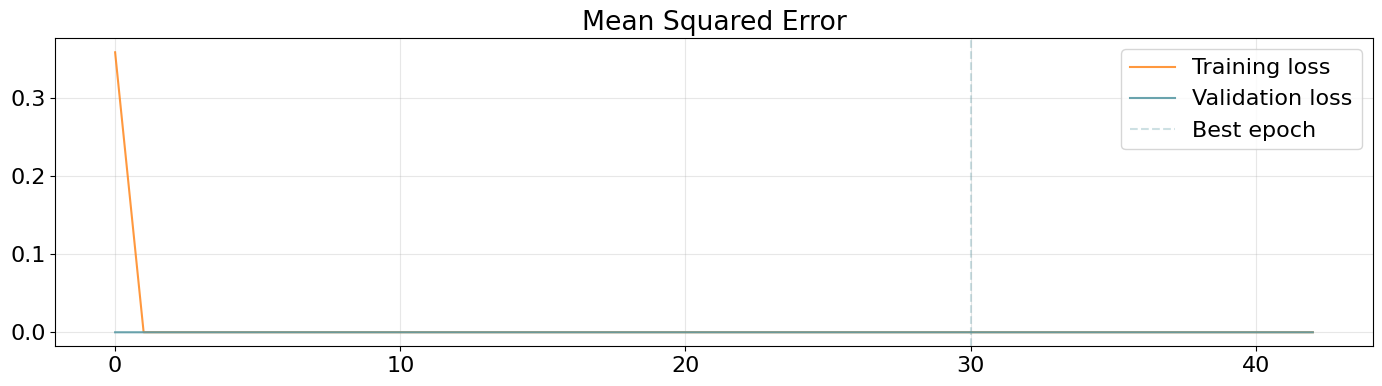

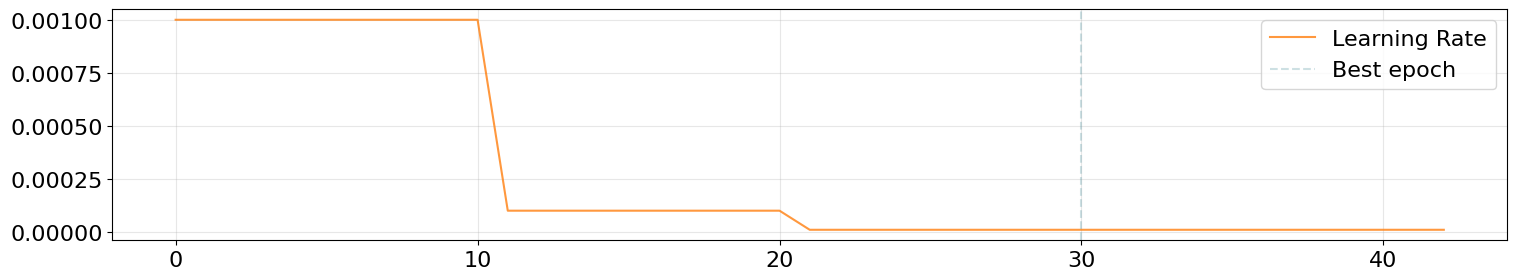

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('first_try_all_series')